In [1]:
from networkx.algorithms.tree.mst import SpanningTreeIterator
import matplotlib.pyplot as plt
import tree_utils as tu
from tqdm import tqdm
import networkx as nx
import numpy as np
import random

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def generate_grid_graph(dims):        
    g = nx.grid_graph(dim=dims)
    # nx.relabel_nodes(g, {node: (N * node[0]) + node[1] + 1 for node in g.nodes}, copy=False)
    for edge in g.edges:
        u, v = edge
        g[u][v]['weight'] = 1
    return g

def enumerate_all_trees(g):
    trees = SpanningTreeIterator(g)
    trees = []
    for tree in tqdm(SpanningTreeIterator(g)):
        trees.append(tree)
    return trees

def sample_trees(g, func, N):
    trees = []
    for _ in tqdm(range(N)):
        tree = func(g)
        trees.append(tree)
    return trees

def make_tree_dict(trees, ds):
    tree_dict = {}
    for tree in tqdm(trees):
        d_dict = {}
        for d in ds:
            d_dict[d] = tu.find_balance_edge(tree, d)
        tree_dict[tree] = d_dict
    return tree_dict

def make_counting_dict(g, tree_dict, ds):
    counting_dict = {}
    for d in ds:
        counting_dict[d] = {e: 0 for e in g.edges}
        for tree in tqdm(tree_dict):
            balance_edges = tree_dict[tree][d]
            for balance_edge in balance_edges:
                counting_dict[d][balance_edge] += 1
    return counting_dict

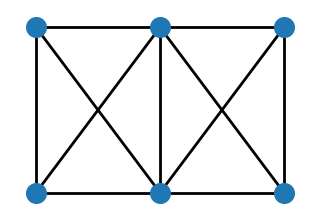

In [100]:
dims = (2, 3)
queen = generate_grid_graph(dims)
# queen.add_edge((0,0),(1, 1))
# queen[(0, 0)][(1, 1)]['weight'] = 1

for i in range(dims[1]-1):
    for j in range(dims[0]):
        if j<(dims[0]-1):
            queen.add_edge((i,j),(i+1,j+1))
            queen[(i,j)][(i+1,j+1)]['weight'] = 1
        if j >0:
            queen.add_edge((i,j),(i+1,j-1))
            queen[(i,j)][(i+1,j-1)]['weight'] = 1
tu.draw(queen)

In [101]:
# queen_trees = sample_trees(queen, tu.uniform_random_spanning_tree, 100000)
queen_trees = enumerate_all_trees(queen)

ds = [0]
queen_tree_dict = make_tree_dict(queen_trees, ds)
queen_counting_dict = make_counting_dict(queen, queen_tree_dict, ds)

192it [00:00, 2778.22it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 1288490.19it/s]


/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_13741/2329373901.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, fraction=0.046, pad=0.01)


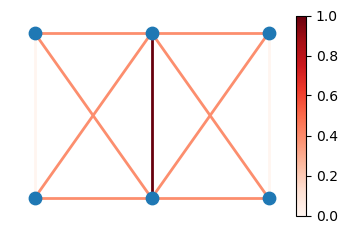

In [102]:
# how often is this edge snappable?
plt.figure(figsize=(dims[1], dims[0])) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(queen,
        pos={(x,y): (x, y) for x,y in queen.nodes()},
        width=2,
        with_labels=False,
        node_size=80,
        edge_color=[queen_counting_dict[0][e] for e in queen.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 75030.87it/s]
/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_13741/99912512.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, fraction=0.046, pad=0.01)


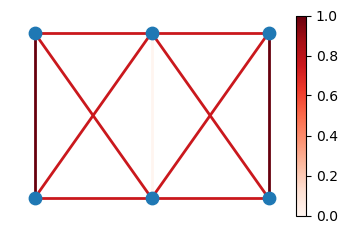

In [106]:
# how often is this edge used in a spanning tree?
counter = {}
for edge in queen.edges: # initialize
    counter[edge] = 0
    
for tree in tqdm(queen_trees):
    for edge in tree.edges:
        counter[edge] += 1

plt.figure(figsize=(dims[1], dims[0])) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(queen,
        pos={(x,y): (x, y) for x,y in queen.nodes()},
        width=2,
        with_labels=False,
        node_size=80,
        edge_color=[counter[e] for e in queen.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_13741/641503238.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, fraction=0.046, pad=0.01)


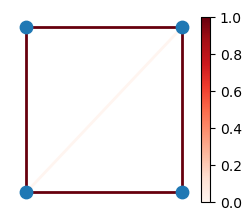

In [61]:
plt.figure(figsize=(dims[1], dims[0])) # this is needed to keep aspect ratio correct
plt.tight_layout()
nx.draw(queen,
        pos={(x,y): (x, y) for x,y in queen.nodes()},
        width=2,
        with_labels=False,
        node_size=80,
        edge_color=[nx.resistance_distance(queen, u, v) for u, v in queen.edges()],
        edge_cmap=plt.cm.Reds
       )
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds)#, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, fraction=0.046, pad=0.01)
plt.show()

In [64]:
inverse_resist = [1/nx.resistance_distance(queen, u, v) for u, v in queen.edges()]
ir_norm = (inverse_resist-np.min(inverse_resist))/(np.max(inverse_resist)-np.min(inverse_resist))
ir_norm

array([0., 0., 1., 0., 0.])

In [53]:
x = [queen_counting_dict[0][e] for e in queen.edges()]
x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
x_norm

/var/folders/p1/b5r1bfts7wzfpyn0b3149s480000gn/T/ipykernel_13741/2215771989.py:2: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-np.min(x))/(np.max(x)-np.min(x))


array([nan, nan, nan, nan])

In [103]:
queen_counting_dict[0]

{((0, 0), (1, 0)): 11,
 ((0, 0), (0, 1)): 4,
 ((0, 0), (1, 1)): 11,
 ((0, 1), (1, 1)): 11,
 ((0, 1), (1, 0)): 11,
 ((1, 0), (2, 0)): 11,
 ((1, 0), (1, 1)): 22,
 ((1, 0), (2, 1)): 11,
 ((1, 1), (2, 1)): 11,
 ((1, 1), (2, 0)): 11,
 ((2, 0), (2, 1)): 4}

In [105]:
len(queen_trees)

192

In [107]:
counter

{((0, 0), (1, 0)): 88,
 ((0, 0), (0, 1)): 96,
 ((0, 0), (1, 1)): 88,
 ((0, 1), (1, 1)): 88,
 ((0, 1), (1, 0)): 88,
 ((1, 0), (2, 0)): 88,
 ((1, 0), (1, 1)): 64,
 ((1, 0), (2, 1)): 88,
 ((1, 1), (2, 1)): 88,
 ((1, 1), (2, 0)): 88,
 ((2, 0), (2, 1)): 96}

In [113]:
for e in queen.edges():
    print(e, " : ", queen_counting_dict[0][e] / counter[e])

((0, 0), (1, 0))  :  0.125
((0, 0), (0, 1))  :  0.041666666666666664
((0, 0), (1, 1))  :  0.125
((0, 1), (1, 1))  :  0.125
((0, 1), (1, 0))  :  0.125
((1, 0), (2, 0))  :  0.125
((1, 0), (1, 1))  :  0.34375
((1, 0), (2, 1))  :  0.125
((1, 1), (2, 1))  :  0.125
((1, 1), (2, 0))  :  0.125
((2, 0), (2, 1))  :  0.041666666666666664
